In [49]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import spacy

from sklearn.metrics import f1_score

from lbl2vec import Lbl2Vec, Lbl2TransformerVec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

In [39]:
def get_spacy_similar_words_for_dataset(dataset_name, predefined_keywords_by_class: dict = None, save_cache=False):
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')

    if predefined_keywords_by_class is None:
        class_keywords = labels_df['class_keywords'].values.tolist()
    else:
        class_keywords = [predefined_keywords_by_class[label] for label in labels_df['class_name']]

    spacy_similarity_model = spacy.load('en_core_web_lg')
    resulting_keywords = {}

    all_documents_words = []
    for doc in documents_df[documents_df['dataset_type'] == 'train']['document']:
        all_documents_words.extend(doc.split(' '))
    all_documents_words = list(set(all_documents_words))

    for class_keyword in class_keywords:
        print(f'[INFO] Processing class keywords: {class_keyword}...' + ' ' * 20, end='\r')

        similarity_levels = []
        
        for word in all_documents_words:
            spacy_word_1 = spacy_similarity_model(word)
            spacy_word_2 = spacy_similarity_model(class_keyword)

            if(not (spacy_word_1 and spacy_word_1.vector_norm and spacy_word_2 and spacy_word_2.vector_norm)):
                continue
            similarity_level = spacy_word_1.similarity(spacy_word_2)

            similarity_levels.append((word, similarity_level))

        similarity_levels = sorted(similarity_levels, key=lambda x: x[1], reverse=True)
        resulting_keywords[class_keyword] = [word for word, _ in similarity_levels]
        
    cache_df = pd.DataFrame()
    cache_df['class_raw_keywords'] = labels_df['class_keywords']
    cache_df['class_result_keywords'] = resulting_keywords.values()

    if save_cache:
        cache_df.to_csv(f'../lbl2vec/cache/{dataset_name}_spacy_keywords.csv', index=False)

    return cache_df

In [2]:
df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
df.head()

,document,class_name,class_index,dataset_type
0,hit shelf combine medium player phone gaming g...,tech,3,train
1,bid hope join host apply host tournament aim r...,sport,1,train
2,lord wrong detainee straw straw attack decisio...,politics,4,train
3,leak answer minister explain budget detail pri...,politics,4,train
4,delight manager pay tribute goal striker beat ...,sport,1,train


In [3]:
def plot_embeddings_2D(embeddings_by_class: dict, model_name: str):
    plt.figure(figsize=(10, 10))

    title = f'Embeddings 2D | {model_name.replace("_", " ").capitalize()}'
    plt.title(title, fontsize=16, fontweight='bold')

    for class_name in embeddings_by_class.keys():
        pts_x, pts_y = [], []
        for pt in embeddings_by_class[class_name]:
            pts_x.append(pt[0])
            pts_y.append(pt[1])

        plt.scatter(pts_x, pts_y, label=class_name)

    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../figures/keyword_analysis_embeddings_2D_{model_name}.png')
    plt.show()

In [4]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['document'])]
doc2vec_model = Doc2Vec(documents, vector_size=2, window=2, min_count=1, workers=4)

doc2vec_model.infer_vector(['this', 'is', 'a', 'test', 'document', 'for', 'doc2vec'])

array([-0.07008486, -0.02803369], dtype=float32)

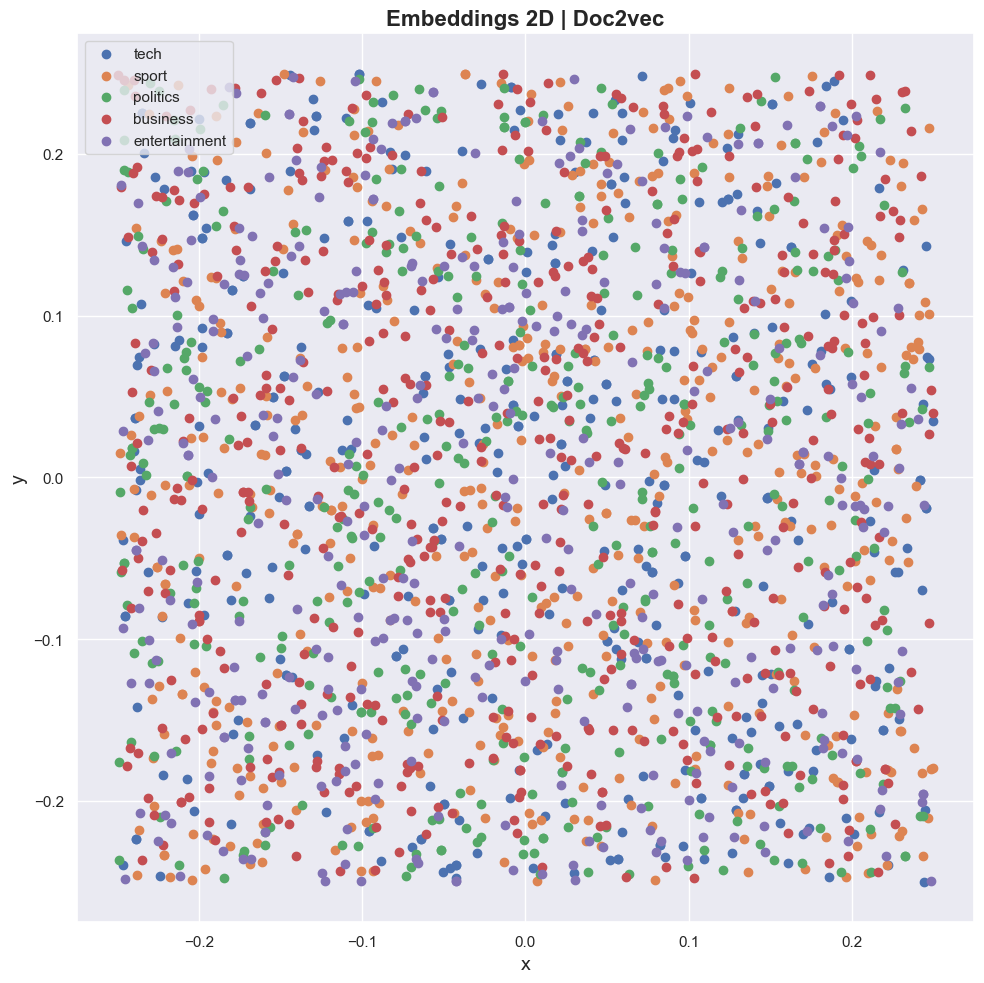

In [5]:
embeddings_by_class = {}
for i, class_name in enumerate(df['class_name'].unique()):
    embeddings_by_class[class_name] = []

for i, doc in enumerate(df['document']):
    vector = doc2vec_model.infer_vector(doc.split(' '))
    embeddings_by_class[df['class_name'][i]].append(vector)

plot_embeddings_2D(embeddings_by_class, 'doc2vec')

In [116]:
class CustomSentenceTransformer(SentenceTransformer):

    def __init__(self, dim: int = 2, model_name_or_path: str = None, **kwargs):
        super().__init__(model_name_or_path, **kwargs)
        self.dim = dim
        self.pca = None

        self.name_or_path = model_name_or_path

    def fit_pca(self, sequences):
        embeddings = super().encode(sequences)
        self.pca = PCA(n_components=self.dim)
        self.pca.fit(embeddings)

    def encode(self, sequences):
        is_str = isinstance(sequences, str)
        if is_str:
            sequences = [sequences]
        embeddings = super().encode(sequences)
        result = self.pca.transform(embeddings).tolist()
        return result[0] if is_str else result

In [ ]:
sentransformer_model = CustomSentenceTransformer(2, 'all-MiniLM-L6-v2')
sentransformer_model.fit_pca(df['document'])
sentransformer_model.encode(df['document'])

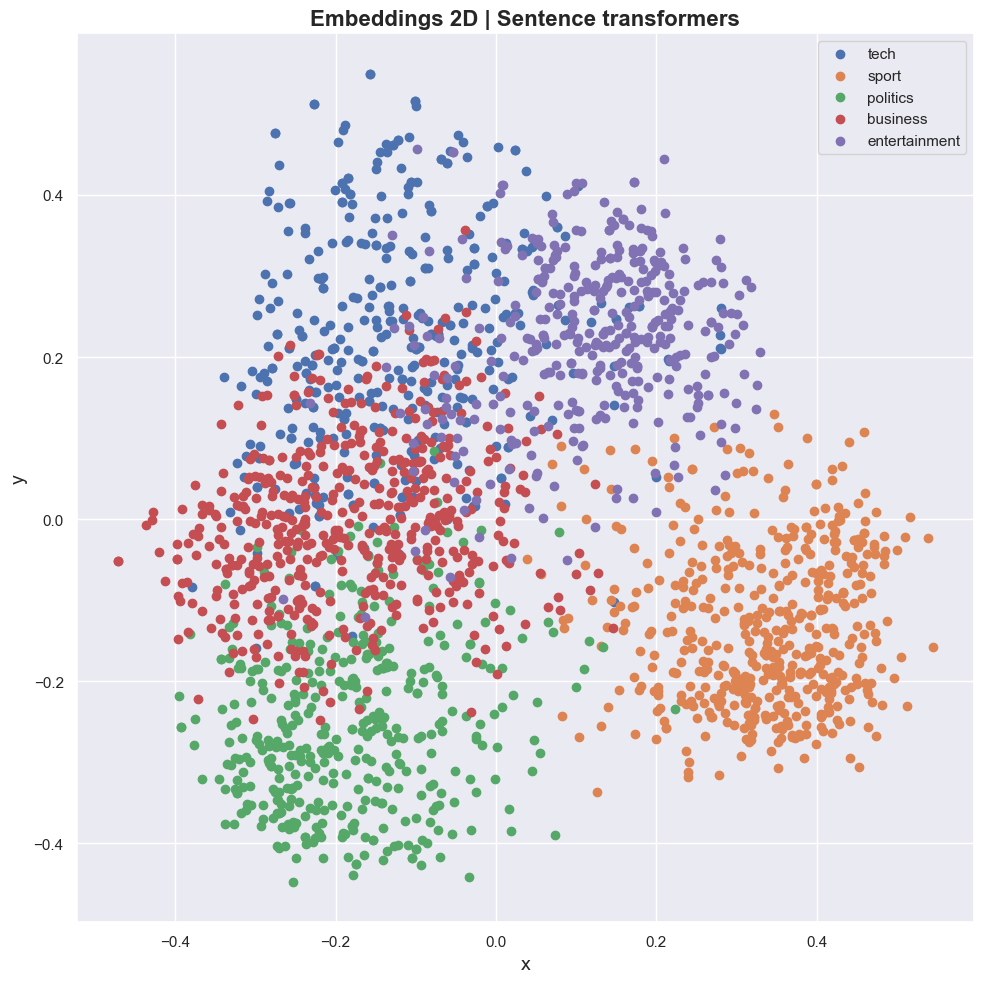

In [107]:
embeddings_by_class = {}
for i, class_name in enumerate(df['class_name'].unique()):
    embeddings_by_class[class_name] = []

for i, doc in enumerate(df['document']):
    vector = sentransformer_model.encode(doc)
    embeddings_by_class[df['class_name'][i]].append(vector)

plot_embeddings_2D(embeddings_by_class, 'sentence_transformers')

In [108]:
def get_2d_embeddings_for_doc(doc: str, model_name: str):
    if model_name == 'doc2vec':
        vector = doc2vec_model.infer_vector(doc.split(' ')) 
        return vector
    elif model_name == 'sentence_transformers':
        vector = sentransformer_model.encode(doc)
        return vector
    
def get_2d_embeddings_for_classes(model_name: str, keywords_used, n_words: int = 1, recompute_spacy_keywords: bool = False):
    if recompute_spacy_keywords:
        get_spacy_similar_words_for_dataset('BBC_News', predefined_keywords_by_class=keywords_used, save_cache=True)
    spacy_keywords_df = pd.read_csv('../lbl2vec/cache/BBC_News_spacy_keywords.csv')
    spacy_keywords_df['class_result_keywords'] = spacy_keywords_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    labels_df = pd.read_csv('../datasets/data/BBC_News/labels.csv')

    embeddings_by_class = {}
    keywords_by_class = {}

    for idx, row in spacy_keywords_df.iterrows():
        class_name = labels_df[labels_df['class_keywords'] == row['class_raw_keywords']]['class_name'].values[0]
        keywords_by_class[class_name] = ' '.join(row['class_result_keywords'][:n_words])

    for class_name in keywords_by_class.keys():
        if model_name == 'doc2vec':
            embeddings_by_class[class_name] = doc2vec_model.infer_vector(keywords_by_class[class_name].split(' '))
        elif model_name == 'sentence_transformers':
            vector = sentransformer_model.encode(keywords_by_class[class_name])
            embeddings_by_class[class_name] = vector

    return embeddings_by_class

In [109]:
def evaluate_lbl2vec_on_dataset(dataset_name: str, keywords_by_class: dict = None, n_iterations: int = 1, n_words: int = 1, dim: int = -1):
    def tokenize(doc):
        return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
    
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['tagged_docs'] = documents_df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)]), axis=1
    )
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    if keywords_by_class is not None:
        get_spacy_similar_words_for_dataset(dataset_name, predefined_keywords_by_class=keywords_by_class, save_cache=True)

    keywords_cached_df = pd.read_csv(f'../lbl2vec/cache/{dataset_name}_spacy_keywords.csv')
    keywords_cached_df['class_result_keywords'] = keywords_cached_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    similar_keywords = dict(zip(keywords_cached_df['class_raw_keywords'], keywords_cached_df['class_result_keywords']))
    labels_df['class_result_keywords'] = labels_df.apply(
        lambda row: similar_keywords[row['class_keywords']][:n_words], axis=1
    )
    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Evaluation
    f1_scores_train = []
    f1_scores_test = []

    for i in range(n_iterations):
        print(f'[INFO] {dataset_name} | Iteration {i+1}/{n_iterations}...' + ' ' * 20, end='\r')

        # -- Model
        lbl2vec_model = Lbl2Vec(
            keywords_list=[item for item in labels_df['class_result_keywords']], 
            tagged_documents=list(documents_df['tagged_docs'][documents_df['dataset_type'] == 'train']), 
            label_names=[item for item in labels_df['class_keywords']], 
            min_count=2,
            vector_size=dim if dim != -1 else 300,
            verbose=False
        )
        lbl2vec_model.fit()

        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=documents_df['tagged_docs'][documents_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        y_true_train = evaluation_train['class_keywords']
        y_pred_train = evaluation_train['most_similar_label']

        y_true_test = evaluation_test['class_keywords']
        y_pred_test = evaluation_test['most_similar_label']

        current_f1_score_train = f1_score(y_true_train, y_pred_train, average='micro')
        current_f1_score_test = f1_score(y_true_test, y_pred_test, average='micro')

        f1_scores_train.append(current_f1_score_train)
        f1_scores_test.append(current_f1_score_test)

        print(f'[INFO] Iteration {i+1}/{n_iterations} - Train F1 Score: {current_f1_score_train:.4f} - Test F1 Score: {current_f1_score_test:.4f}' + ' ' * 40, end='\r')

    current_f1_score_train = sum(f1_scores_train) / len(f1_scores_train)
    current_f1_score_test = sum(f1_scores_test) / len(f1_scores_test)
    return current_f1_score_train, current_f1_score_test

In [121]:
def evaluate_lbl2transformervec_on_dataset(dataset_name: str, keywords_by_class: dict = None, dim: int = -1):
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    if keywords_by_class is not None:
        documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: keywords_by_class[class_name])

    # -- Evaluation
    print(f'[INFO] {dataset_name}...' + ' ' * 20, end='\r')

    # -- Model
    lbl2vec_model = Lbl2TransformerVec(
        transformer_model=CustomSentenceTransformer(dim=dim, model_name_or_path='sentence-transformers/all-MiniLM-L6-v2'),
        keywords_list=[item.split(' ') for item in labels_df['class_keywords']], 
        documents=list(documents_df['document'][documents_df['dataset_type'] == 'train']), 
        label_names=[item for item in labels_df['class_keywords']], 
        verbose=False
    )
    lbl2vec_model.fit()

    train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
    test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(documents=documents_df['document'][documents_df['dataset_type'] == 'test'])

    train_docs_lbl_similarities['doc_key'] = list(documents_df['doc_key'][documents_df['dataset_type'] == 'train'])
    test_docs_lbl_similarities['doc_key'] = list(documents_df['doc_key'][documents_df['dataset_type'] == 'test'])

    evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
    evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

    y_true_train = evaluation_train['class_keywords']
    y_pred_train = evaluation_train['most_similar_label']

    y_true_test = evaluation_test['class_keywords']
    y_pred_test = evaluation_test['most_similar_label']

    current_f1_score_train = f1_score(y_true_train, y_pred_train, average='micro')
    current_f1_score_test = f1_score(y_true_test, y_pred_test, average='micro')

    print(f'[INFO] Train F1 Score: {current_f1_score_train:.4f} - Test F1 Score: {current_f1_score_test:.4f}' + ' ' * 50, end='\r')

    return current_f1_score_train, current_f1_score_test

In [122]:
evaluate_lbl2transformervec_on_dataset('BBC_News', dim=2)

TypeError: forward() got an unexpected keyword argument 'input_ids'

In [77]:
def compare_embeddings_by_keywords(keywords_by_class: dict):
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('Embeddings 2D', fontsize=20, fontweight='bold')

    keywords_by_class_df = pd.read_csv('../datasets/data/BBC_News/labels.csv')
    subtitles = [f'[{class_name}]: {keywords_by_class_df[keywords_by_class_df["class_name"] == class_name]["class_keywords"].values[0]}' for class_name in keywords_by_class_df['class_name'].unique()]
    fig.text(0.5, 0.84, '\n'.join(subtitles), ha='center', fontsize=14)
    fig.tight_layout(pad=5.0)

    colors = ['red', 'blue', 'green', 'orange', 'purple']
    model_names = ['doc2vec', 'sentence_transformers']

    for i, model_name in enumerate(model_names):
        for j, class_name in enumerate(df['class_name'].unique()):
            pts_x, pts_y = [], []
            for doc in df[df['class_name'] == class_name]['document']:
                vector = get_2d_embeddings_for_doc(doc, model_name)
                pts_x.append(vector[0])
                pts_y.append(vector[1])

            ax[i].scatter(pts_x, pts_y, label=class_name, color=colors[j], s=10)

    should_recompute_spacy_keywords = False

    for i, model_name in enumerate(model_names):
        embeddings_by_class = get_2d_embeddings_for_classes(model_name, keywords_by_class, n_words=20, recompute_spacy_keywords=should_recompute_spacy_keywords)
        should_recompute_spacy_keywords = False

        for j, class_name in enumerate(df['class_name'].unique()):
            ax[i].scatter(embeddings_by_class[class_name][0], embeddings_by_class[class_name][1], marker='o', s=200, color=colors[j], edgecolors='white')

        ax[i].set_xlabel('x', fontsize=14)
        ax[i].set_ylabel('y', fontsize=14)
        ax[i].set_title(f'{model_name.replace("_", " ").capitalize()}', fontsize=16, fontweight='bold')
        ax[i].legend()

    lbl2vec_train_f1, lbl2vec_test_f1 = evaluate_lbl2vec_on_dataset('BBC_News', n_iterations=5, n_words=20)
    lbl2transformervec_train_f1, lbl2transformervec_test_f1 = evaluate_lbl2transformervec_on_dataset('BBC_News')

    f1_scores_df = pd.DataFrame()
    f1_scores_df['model_name'] = ['lbl2vec', 'lbl2transformervec']
    f1_scores_df['Train'] = [lbl2vec_train_f1, lbl2transformervec_train_f1]
    f1_scores_df['Test'] = [lbl2vec_test_f1, lbl2transformervec_test_f1]
    f1_scores_df = pd.melt(f1_scores_df, id_vars=['model_name'], value_vars=['Train', 'Test'], var_name='Dataset Type', value_name='f1_score')

    sns.barplot(ax=ax[2], data=f1_scores_df, x='model_name', y='f1_score', hue='Dataset Type')
    ax[2].set_xlabel('Model', fontsize=14)
    ax[2].set_ylabel('F1 Score', fontsize=14)
    ax[2].set_title('F1 Score Comparison', fontsize=16, fontweight='bold')

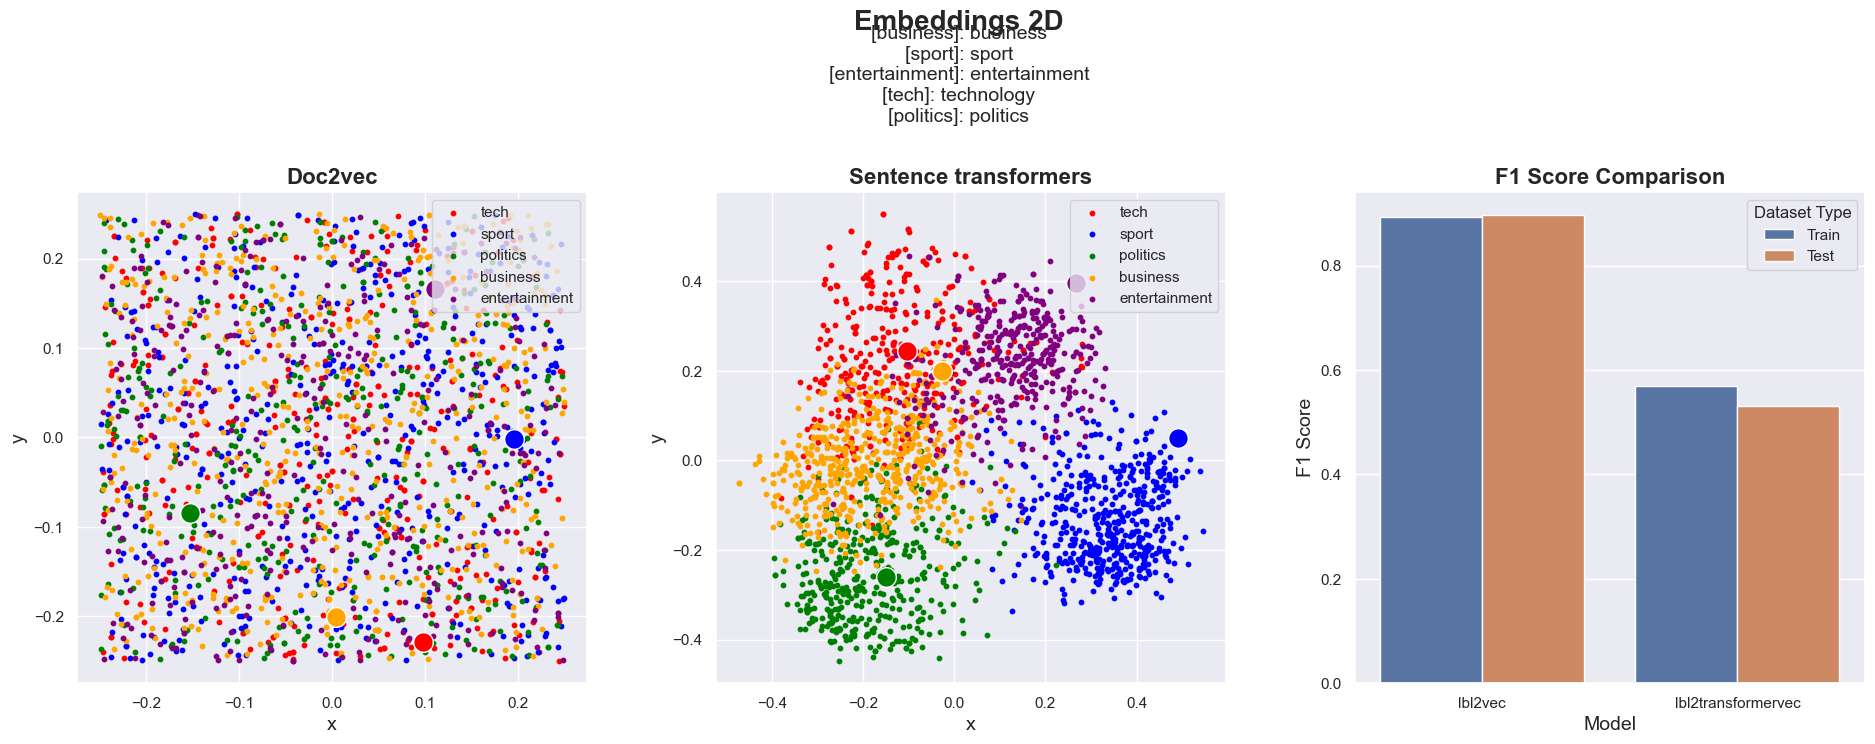

In [78]:
compare_embeddings_by_keywords({'business': 'business', 'entertainment': 'entertainment', 'politics': 'politics', 'sport': 'sport', 'tech': 'tech'})